In [6]:
# from algoshort.yfinance_handler import YFinanceDataHandler
# handler = YFinanceDataHandler(cache_dir="./cache")
# symbols = handler.list_cached_symbols()
# handler.download_data(symbols, use_cache=True)
# df = handler.get_ohlc_data('A2A.MI')

In [7]:
from algoshort.yfinance_handler import YFinanceDataHandler
handler = YFinanceDataHandler(cache_dir="./cache")

from datetime import date
handler.download_data(['MONC.MI', 'FTSEMIB.MI'], start='2016-01-01', end=date.today(), use_cache=False)

2026-01-14 07:40:45,405 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 2
2026-01-14 07:40:45,405 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 2
2026-01-14 07:40:45,405 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 2
2026-01-14 07:40:45,405 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Downloading 2 symbols in 1 chunks of 50
2026-01-14 07:40:45,405 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Downloading 2 symbols in 1 chunks of 50
2026-01-14 07:40:45,405 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Downloading 2 symbols in 1 chunks of 50
[*********************100%***********************]  2 of 2 completed
2026-01-14 07:40:45,465 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Successfully processed 2/2 symbols
2026-01-14 07:40:45,465 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Successfully pr

{'MONC.MI': Price            open       high        low      close   volume
 Date                                                           
 2016-01-04  11.405757  11.405757  10.836359  11.076573  2223179
 2016-01-05  11.210026  11.245613  10.809667  10.969810  1649453
 2016-01-06  10.987604  11.014294  10.720699  10.845254  1682315
 2016-01-07  10.569453  11.076573  10.053436  10.898636  2789127
 2016-01-08  10.952018  11.094367  10.774080  10.987605  1492468
 ...               ...        ...        ...        ...      ...
 2026-01-07  54.500000  54.520000  51.919998  53.000000  1878153
 2026-01-08  52.700001  53.220001  52.419998  53.080002   710870
 2026-01-09  52.779999  54.279999  52.439999  54.119999   937098
 2026-01-12  54.419998  54.419998  52.860001  53.599998   668952
 2026-01-13  53.400002  53.419998  52.660000  53.240002   665244
 
 [2548 rows x 5 columns],
 'FTSEMIB.MI': Price          open     high      low    close       volume
 Date                                    

In [8]:
df = handler.get_data('MONC.MI')
df = handler.get_ohlc_data('MONC.MI')
bmk = handler.get_ohlc_data('FTSEMIB.MI')
bmk

Price,date,open,high,low,close
0,2016-01-04,21186.0,21194.0,20702.0,20734.0
1,2016-01-05,20938.0,20983.0,20722.0,20983.0
2,2016-01-06,20922.0,20931.0,20373.0,20422.0
3,2016-01-07,19778.0,20289.0,19629.0,20189.0
4,2016-01-08,20189.0,20350.0,19869.0,19869.0
...,...,...,...,...,...
2542,2026-01-07,45778.0,45978.0,45559.0,45559.0
2543,2026-01-08,45426.0,45715.0,45420.0,45672.0
2544,2026-01-09,45757.0,45780.0,45577.0,45719.0
2545,2026-01-12,45547.0,45770.0,45378.0,45732.0


In [9]:
from algoshort.ohlcprocessor import OHLCProcessor
processor = OHLCProcessor()
df = processor.calculate_relative_prices(
    stock_data= df,
    benchmark_data= bmk
    )


2026-01-14 07:40:45,508 - INFO - Merging primary data (shape: (2548, 5)) with benchmark data (shape: (2547, 5)).
2026-01-14 07:40:45,510 - INFO - Merge completed. New DataFrame shape: (2548, 6)
2026-01-14 07:40:45,512 - INFO - Rebasing benchmark to 1.0 using the first value: 20734.0
2026-01-14 07:40:45,512 - INFO - Calculating relative OHLC prices...
2026-01-14 07:40:45,514 - INFO - Relative price calculation complete.


In [10]:
# df.columns
# df.columns.name = None
# df.columns.name

In [11]:
from algoshort.regime_fc import RegimeFC
from algoshort.utils import load_config
config_path = './config.json'

config = load_config(config_path)


In [12]:
regime_fc = RegimeFC(df)
df = regime_fc.compute_regime(
        relative = True,
        lvl = config['regimes']['floor_ceiling']['lvl'],
        vlty_n = config['regimes']['floor_ceiling']['vlty_n'],
        threshold = config['regimes']['floor_ceiling']['threshold'],
        dgt = config['regimes']['floor_ceiling']['dgt'],
        d_vol = config['regimes']['floor_ceiling']['d_vol'],
        dist_pct = config['regimes']['floor_ceiling']['dist_pct'],
        retrace_pct = config['regimes']['floor_ceiling']['retrace_pct'],
        r_vol = config['regimes']['floor_ceiling']['r_vol']
    )


2026-01-14 07:40:49,292 - algoshort.regime_fc.RegimeFC - INFO - Initialized Regime_fc with DataFrame of shape (2548, 9)
2026-01-14 07:40:49,292 - INFO - Initialized Regime_fc with DataFrame of shape (2548, 9)
2026-01-14 07:40:49,294 - algoshort.regime_fc.RegimeFC - INFO - Starting regime analysis (relative=True)
2026-01-14 07:40:49,294 - INFO - Starting regime analysis (relative=True)
2026-01-14 07:40:49,294 - algoshort.regime_fc.RegimeFC - INFO - Starting swings analysis (relative=True)
2026-01-14 07:40:49,294 - INFO - Starting swings analysis (relative=True)
2026-01-14 07:40:49,296 - algoshort.regime_fc.RegimeFC - INFO - Starting historical_swings analysis (relative=True)
2026-01-14 07:40:49,296 - INFO - Starting historical_swings analysis (relative=True)
2026-01-14 07:40:49,314 - algoshort.regime_fc.RegimeFC - INFO - historical_swings completed with 4 swing levels
2026-01-14 07:40:49,314 - INFO - historical_swings completed with 4 swing levels
2026-01-14 07:40:49,326 - algoshort.reg

In [13]:
# rhs = ['hi1', 'lo1','hi2', 'lo2', 'hi3', 'lo3']
# rrhs = ['rh1', 'rl1','rh2', 'rl2', 'rh3', 'rl3']
# rt_hi,rt_lo,_hi,_lo,shi,slo = [rhs[h] for h in range(len(rhs))]
# rt_hi,rt_lo,_hi,_lo,shi,slo = [rrhs[h] for h in range(len(rrhs))]
# rt_hi,rt_lo,_hi,_lo,shi,slo

In [14]:
# de = regime_fc.cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo)
# df.describe()

In [15]:
# ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = regime_fc.latest_swing_variables(df,shi,slo,rt_hi,rt_lo,'rhigh','rlow', 'rclose')

In [16]:
# df = regime_fc.swings(df, rel=True, config_path='./config.json')
# df

In [17]:
# df.describe()

In [18]:
# df = regime_fc.regime(df, rel=True, config_path='./config.json')
# df

In [19]:
ticker = 'MONC.MI'
bm_name = 'FTSEMIB.MI'

In [20]:
df

Price,date,open,high,low,close,ropen,rhigh,rlow,rclose,rh1,...,rl2,rh3,rl3,rh4,rl4,rrt,rrg,rflr,rclg,rrg_ch
0,2016-01-04,11.405757,11.405757,10.836359,11.076573,11.4058,11.4058,10.8364,11.0766,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,11.210026,11.245613,10.809667,10.969810,11.0770,11.1122,10.6814,10.8396,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,10.987604,11.014294,10.720699,10.845254,11.1555,11.1826,10.8845,11.0109,11.1826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,10.8548,11.3756,10.3248,11.1928,NaN,...,10.3248,NaN,NaN,NaN,NaN,NaN,NaN,10.3248,NaN,NaN
4,2016-01-08,10.952018,11.094367,10.774080,10.987605,11.4288,11.5774,11.2431,11.4660,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2026-01-07,54.500000,54.520000,51.919998,53.000000,24.8031,24.8122,23.6289,24.1204,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,41.4525
2544,2026-01-08,52.700001,53.220001,52.419998,53.080002,23.9245,24.1606,23.7974,24.0971,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,41.4525
2545,2026-01-09,52.779999,54.279999,52.439999,54.119999,23.9362,24.6165,23.7820,24.5439,24.6165,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,41.4525
2546,2026-01-12,54.419998,54.419998,52.860001,53.599998,24.6730,24.6730,23.9657,24.3012,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,41.4525


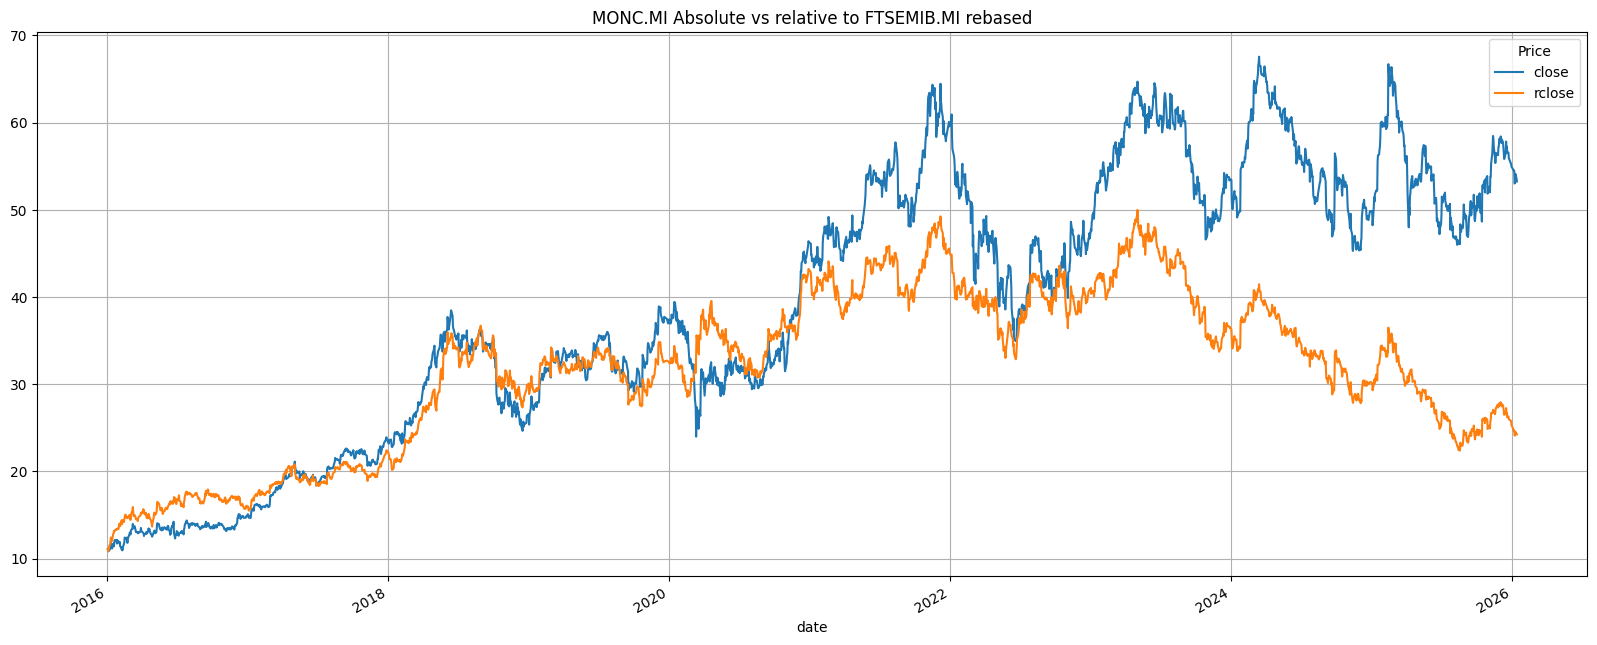

In [21]:
from algoshort.plots import *

plot_abs_rel(df=df, ticker=ticker, bm_name=bm_name)

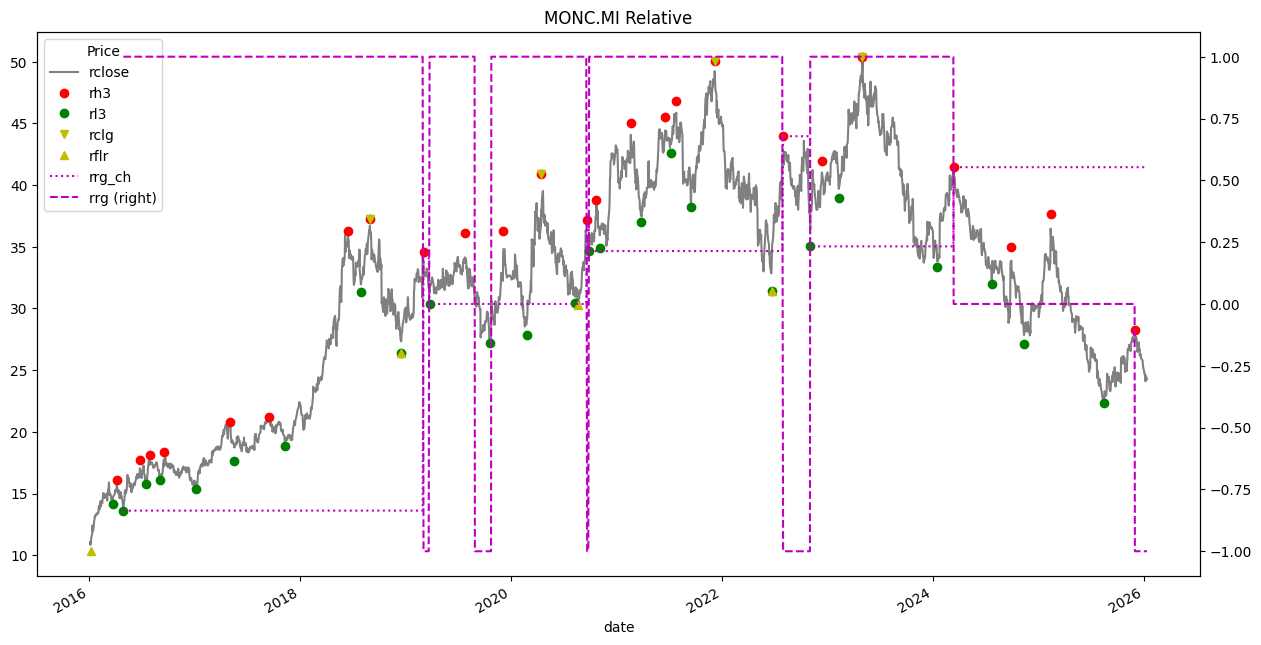

In [22]:
plot_signal_rel(df, ticker=ticker)

In [23]:
# plot_regime_rel(df, ticker)

In [24]:
from algoshort.ohlcprocessor import OHLCProcessor
from algoshort.wrappers import generate_signals, calculate_risk_metrics, calculate_return, calculate_trading_edge

In [134]:
# def TA(symbol, benchmark, cache_dir, config_path):

#     processor = OHLCProcessor()
#     stock_data = processor.calculate_relative_prices(
#         stock_data= df,
#         benchmark_data= bmk
#         )
#     stock_data, signal_columns = generate_signals(stock_data)
#     stock_data = calculate_return(stock_data, config_path=config_path, signal_columns=signal_columns)
#     # stock_data = calculate_metrics(stock_data, config_path=config_path)
#     return stock_data


# ta = TA(symbol='A2A.MI', benchmark='FTSEMIB.MI', cache_dir = './cache', config_path='config.json')
# ta

In [25]:
from algoshort.regime_bo import RegimeBO
regime_bo = RegimeBO(ohlc_stock=df)
regime_bo.compute_regime(regime_type='turtle', fast_window=20,
                             window=50,
                             relative=True, inplace=True)


Price,date,open,high,low,close,ropen,rhigh,rlow,rclose,rh1,...,rflr,rclg,rrg_ch,rhi_50,rlo_50,rhi_20,rlo_20,rbo_50,rbo_20,rtt_5020
0,2016-01-04,11.405757,11.405757,10.836359,11.076573,11.4058,11.4058,10.8364,11.0766,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2016-01-05,11.210026,11.245613,10.809667,10.969810,11.0770,11.1122,10.6814,10.8396,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2016-01-06,10.987604,11.014294,10.720699,10.845254,11.1555,11.1826,10.8845,11.0109,11.1826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,10.8548,11.3756,10.3248,11.1928,NaN,...,10.3248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2016-01-08,10.952018,11.094367,10.774080,10.987605,11.4288,11.5774,11.2431,11.4660,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2026-01-07,54.500000,54.520000,51.919998,53.000000,24.8031,24.8122,23.6289,24.1204,NaN,...,NaN,NaN,41.4525,28.2925,23.6289,27.9191,23.6289,-1.0,-1.0,-1
2544,2026-01-08,52.700001,53.220001,52.419998,53.080002,23.9245,24.1606,23.7974,24.0971,NaN,...,NaN,NaN,41.4525,28.2925,23.6289,27.9076,23.6289,-1.0,-1.0,-1
2545,2026-01-09,52.779999,54.279999,52.439999,54.119999,23.9362,24.6165,23.7820,24.5439,24.6165,...,NaN,NaN,41.4525,28.2925,23.6289,27.9076,23.6289,-1.0,-1.0,-1
2546,2026-01-12,54.419998,54.419998,52.860001,53.599998,24.6730,24.6730,23.9657,24.3012,NaN,...,NaN,NaN,41.4525,28.2925,23.6289,27.5502,23.6289,-1.0,-1.0,-1


In [26]:
search_space = {
    'fast': [10, 20],
    'slow': [50, 50]
}

# search_space = {
#     'fast': [20],
#     'slow': [50]
# }

for w_val, m_val in zip(*search_space.values()):
    print(f"Index Match -> Window: {w_val}, Multiplier: {m_val}")
    regime_bo.compute_regime(regime_type='turtle', fast_window=w_val,
                             window=m_val,
                             relative=True, inplace=True)

Index Match -> Window: 10, Multiplier: 50
Index Match -> Window: 20, Multiplier: 50


In [137]:
# df.columns

In [27]:
# Includes any column starting with 'rtt_' OR exactly matching 'rrg'
signal_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in ['rtt_'])]
signal_columns

['rtt_5020', 'rtt_5010']

In [28]:
import pandas as pd
import numpy as np

# Loop to create a new 'filtered' column for each strategy
for col in signal_columns:
    new_col_name = f"{col}_in_regime"
    
    # Logic: If Signal == Regime, use Signal, else 0
    df[new_col_name] = np.where(df[col] == df['rrg'], df[col], 0)

In [29]:
signal_columns_in_regime = [col for col in df.columns if any(col.endswith(prefix) for prefix in ['regime'])]
signal_columns_in_regime

['rtt_5020_in_regime', 'rtt_5010_in_regime']

In [141]:
# df.columns

In [30]:
signal_columns = signal_columns + signal_columns_in_regime
signal_columns

['rtt_5020', 'rtt_5010', 'rtt_5020_in_regime', 'rtt_5010_in_regime']

In [31]:
df = calculate_return(df, config_path=config_path, signal_columns=signal_columns)
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'ropen', 'rhigh', 'rlow',
       'rclose', 'rh1', 'rl1', 'rh2', 'rl2', 'rh3', 'rl3', 'rh4', 'rl4', 'rrt',
       'rrg', 'rflr', 'rclg', 'rrg_ch', 'rhi_50', 'rlo_50', 'rhi_20', 'rlo_20',
       'rbo_50', 'rbo_20', 'rtt_5020', 'rhi_10', 'rlo_10', 'rbo_10',
       'rtt_5010', 'rtt_5020_in_regime', 'rtt_5010_in_regime',
       'rtt_5020_chg1D', 'rtt_5020_chg1D_fx', 'rtt_5020_PL_cum',
       'rtt_5020_PL_cum_fx', 'rtt_5020_returns', 'rtt_5020_log_returns',
       'rtt_5020_cumul', 'rtt_5010_chg1D', 'rtt_5010_chg1D_fx',
       'rtt_5010_PL_cum', 'rtt_5010_PL_cum_fx', 'rtt_5010_returns',
       'rtt_5010_log_returns', 'rtt_5010_cumul', 'rtt_5020_in_regime_chg1D',
       'rtt_5020_in_regime_chg1D_fx', 'rtt_5020_in_regime_PL_cum',
       'rtt_5020_in_regime_PL_cum_fx', 'rtt_5020_in_regime_returns',
       'rtt_5020_in_regime_log_returns', 'rtt_5020_in_regime_cumul',
       'rtt_5010_in_regime_chg1D', 'rtt_5010_in_regime_chg1D_fx',
       'rtt_5010_

In [144]:
# df[[col for col in df.columns if col.endswith('_cumul')]]

In [145]:
# from algoshort.stop_loss import StopLossCalculator
# calc = StopLossCalculator(df)
# s = 'rtt_5020'
# w = 14
# m = 2
# price_col = 'close'
# df = calc.atr_stop_loss(price_col = price_col, signal=s, window=w, multiplier=m)
# stop_loss_name = s + '_stop_loss'
# change_name = s + '_chg1D_fx'


In [146]:
# from algoshort.position_sizing import PositionSizing
# pos = PositionSizing(df)
# df['fx'] = 1
# pos = PositionSizing(df)
# df = pos.compare_position_sizing(df=df, signal=s, price_col=price_col, stop_loss_col=stop_loss_name, daily_change_col = change_name, inplace=False)
# df[['constant', 'concave', 'convex', 'equal_weight']].tail(1)

In [32]:
from algoshort.stop_loss import StopLossCalculator
from algoshort.position_sizing import PositionSizing
import itertools

In [33]:
def get_equity(is_data, signal, price_col = 'close'):
    # calc = StopLossCalculator(is_data)

    # temp_df = calc.atr_stop_loss(signal=signal, window=w, multiplier=m, price_col='close')

    pos = PositionSizing(is_data)
    df = pos.compare_position_sizing(df=is_data, signal=signal, price_col=price_col, stop_loss_col=signal + '_stop_loss', daily_change_col = signal + '_chg1D_fx', inplace=False)
    # return df
    metrics_df = df[['constant', 'concave', 'convex', 'equal_weight']]
    row = metrics_df.iloc[-1].to_dict()
    # row.update({'window': w, 'multiplier': m})
    return row

In [34]:
import pandas as pd
import numpy as np
import itertools

class StrategyOptimizer:
    def __init__(self, data: pd.DataFrame, calculator: StopLossCalculator, equity_func):
        """
        Args:
            data: The full OHLC DataFrame.
            calculator: An instance of StopLossCalculator.
            equity_func: Your custom function that returns a 1-row, 4-col DataFrame.
        """
        self.data = data
        self.calc = calculator
        self.equity_func = equity_func
        self.optimization_results = pd.DataFrame()
        self.best_params = {}

   
    def run_grid_search(self, is_data, signal, windows, multipliers, price_col = 'close'):
        """Performs a standard grid search on a specific data segment."""
        results = []
        self.calc.data = is_data
        
        for w, m in itertools.product(windows, multipliers):
            temp_df = self.calc.atr_stop_loss(signal=signal, window=w, multiplier=m, price_col=price_col)
            row = self.equity_func(temp_df, signal, price_col = price_col)
            row.update({'window': w, 'multiplier': m})
            results.append(row)
            
        return pd.DataFrame(results)

    def rolling_walk_forward(self, signal, close_col, windows, multipliers, n_segments=4):
        """Executes a rolling WFA and returns OOS metrics and parameter stability."""
        segment_size = len(self.data) // (n_segments + 1)
        print(f"Debug: Data Length: {len(self.data)}, Segments: {n_segments}")
        oos_results = []
        param_history = []

        for i in range(n_segments):
            # Define Splits
            is_data = self.data.iloc[i * segment_size : (i + 1) * segment_size]
            oos_data = self.data.iloc[(i + 1) * segment_size : (i + 2) * segment_size]

            # In-Sample Optimization
            is_df = self.run_grid_search(is_data, signal, windows, multipliers, price_col = close_col)
            best_row = is_df.sort_values('convex', ascending=False).iloc[0]
            
            w_best, m_best = int(best_row['window']), best_row['multiplier']
            param_history.append({'segment': i+1, 'window': w_best, 'multiplier': m_best})

            # Out-of-Sample Validation
            self.calc.data = oos_data
            final_oos = self.calc.atr_stop_loss(signal, window=w_best, multiplier=m_best, price_col=close_col)
            oos_metrics = self.equity_func(final_oos, signal, close_col)
            oos_metrics['segment'] = i + 1
            # oos_metrics['w_best'] = w_best
            # oos_metrics['m_best'] = m_best
            oos_results.append(oos_metrics)

            # # Update the placeholder every loop
            # self.final_best_params = {
            #     'window': w_best,
            #     'multiplier': m_best,
            #     'segment_index': i
            # }

        # Calculate Stability
        history_df = pd.DataFrame(param_history)
        stability = {
            'window_cv': history_df['window'].std() / history_df['window'].mean(),
            'multiplier_cv': history_df['multiplier'].std() / history_df['multiplier'].mean()
        }
        
        # return pd.DataFrame(oos_results)
        return pd.DataFrame(oos_results), stability, param_history

    def sensitivity_analysis(self, signal, best_w, best_m, variance=0.2):
        """Tests the 'plateau' around the optimal parameters."""
        w_range = [int(best_w * r) for r in [1-variance, 1, 1+variance]]
        m_range = [round(best_m * r, 2) for r in [1-variance, 1, 1+variance]]
        
        # Test on full data
        self.calc.data = self.data
        results = self.run_grid_search(self.data, signal, w_range, m_range)
        
        peak_equity = results[(results['window']==best_w) & (results['multiplier']==best_m)]['convex'].iloc[0]
        avg_equity = results['convex'].mean()
        
        return (avg_equity / peak_equity) * 100, results

In [35]:
df['fx'] = 1
df2 = df[['date', 'open', 'high', 'low', 'close', 'fx', 'rtt_5020', 'rtt_5010', 'fx', 'rtt_5010_chg1D_fx', 'rtt_5020_chg1D_fx']].reset_index()
df2

Price,index,date,open,high,low,close,fx,rtt_5020,rtt_5010,fx,rtt_5010_chg1D_fx,rtt_5020_chg1D_fx
0,0,2016-01-04,11.405757,11.405757,10.836359,11.076573,1,0,0,1,NaN,NaN
1,1,2016-01-05,11.210026,11.245613,10.809667,10.969810,1,0,0,1,-0.000000,-0.000000
2,2,2016-01-06,10.987604,11.014294,10.720699,10.845254,1,0,0,1,-0.000000,-0.000000
3,3,2016-01-07,10.569453,11.076573,10.053436,10.898636,1,0,0,1,0.000000,0.000000
4,4,2016-01-08,10.952018,11.094367,10.774080,10.987605,1,0,0,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2543,2026-01-07,54.500000,54.520000,51.919998,53.000000,1,-1,-1,1,1.480000,1.480000
2544,2544,2026-01-08,52.700001,53.220001,52.419998,53.080002,1,-1,-1,1,-0.080002,-0.080002
2545,2545,2026-01-09,52.779999,54.279999,52.439999,54.119999,1,-1,-1,1,-1.039997,-1.039997
2546,2546,2026-01-12,54.419998,54.419998,52.860001,53.599998,1,-1,-1,1,0.520000,0.520000


In [36]:
# 1. Setup
calc = StopLossCalculator(df2)
optimizer = StrategyOptimizer(df2, calc, get_equity)

# 2. Run Rolling Walk-Forward
windows = [10, 15, 20]
multipliers = [1.5, 2.5]
oos_df, stability, param_history = optimizer.rolling_walk_forward(
    signal='rtt_5010', 
    close_col = 'close',
    windows=windows, 
    multipliers=multipliers,
    n_segments=10
)
oos_df

Debug: Data Length: 2548, Segments: 10


ValueError: Error computing position sizing comparison: 'DataFrame' object has no attribute 'dtype'

In [105]:
param_history

[{'segment': 1, 'window': 10, 'multiplier': np.float64(1.5)},
 {'segment': 2, 'window': 20, 'multiplier': np.float64(2.5)},
 {'segment': 3, 'window': 15, 'multiplier': np.float64(1.5)},
 {'segment': 4, 'window': 20, 'multiplier': np.float64(2.5)},
 {'segment': 5, 'window': 20, 'multiplier': np.float64(2.5)},
 {'segment': 6, 'window': 10, 'multiplier': np.float64(2.5)},
 {'segment': 7, 'window': 10, 'multiplier': np.float64(2.5)},
 {'segment': 8, 'window': 10, 'multiplier': np.float64(1.5)},
 {'segment': 9, 'window': 10, 'multiplier': np.float64(1.5)},
 {'segment': 10, 'window': 15, 'multiplier': np.float64(1.5)}]

In [106]:
stability

{'window_cv': np.float64(0.3281916369545291),
 'multiplier_cv': np.float64(0.26352313834736496)}

In [107]:
optimizer.sensitivity_analysis(signal='rtt_5020', best_w=15, best_m=1.5)

(np.float64(100.1238554328473),
        constant       concave        convex   equal_weight  window  multiplier
 0  1.004828e+06  1.002144e+06  1.002144e+06  988271.172285      12         1.2
 1  1.004956e+06  1.004201e+06  1.004201e+06  988271.172285      12         1.5
 2  1.004862e+06  1.004828e+06  1.004828e+06  988271.172285      12         1.8
 3  1.005177e+06  1.002031e+06  1.002031e+06  988271.172285      15         1.2
 4  1.004877e+06  1.004215e+06  1.004215e+06  988271.172285      15         1.5
 5  1.004585e+06  1.005177e+06  1.005177e+06  988271.172285      15         1.8
 6  1.009293e+06  1.008020e+06  1.008020e+06  988271.172285      18         1.2
 7  1.008396e+06  1.009223e+06  1.009223e+06  988271.172285      18         1.5
 8  1.007571e+06  1.009293e+06  1.009293e+06  988271.172285      18         1.8)

In [112]:
# List of your signals
signals_to_test = ['rtt_5020', 'rtt_5010'] 

# Storage for results
all_oos_data = {}
strategy_comparison = []

for sig in signals_to_test:
    print(f"--- Optimizing Strategy: {sig} ---")
    
    # 1. Run Walk-Forward
    oos_df, stability, history = optimizer.rolling_walk_forward(
        signal=sig, 
        close_col='close', 
        windows=windows, 
        multipliers=multipliers
    )
    
    # ADD THIS CHECK:
    if not history or len(history) == 0:
        print(f"Skipping {sig}: Not enough data or no segments generated.")
        continue # Move to the next signal
    
    # 2. Run Sensitivity on the latest best parameters
    last_best = history[-1]
    sens_score, sens_df = optimizer.sensitivity_analysis(
        signal=sig,
        best_w=last_best['window'],
        best_m=last_best['multiplier']
    )
    
    # 3. Save Summary Data
    strategy_comparison.append({
        'Signal': sig,
        'Latest_Window': last_best['window'],
        'Latest_Mult': last_best['multiplier'],
        'Window_CV': stability['window_cv'],
        'Mult_CV': stability['multiplier_cv'],
        'Sensitivity_Score': sens_score,
        'Final_Equity': oos_df['convex'].iloc[-1] # or your preferred metric
    })
    
    # Store the full OOS equity curve for plotting
    all_oos_data[sig] = oos_df

# Convert to DataFrame for easy analysis
comparison_df = pd.DataFrame(strategy_comparison)

--- Optimizing Strategy: rtt_5020 ---
--- Optimizing Strategy: rtt_5010 ---


KeyError: 'rtt_5010'

In [ ]:
# Define your "Robustness" thresholds
def filter_strategies(df):
    # Only keep strategies with stable parameters and a robust plateau
    safe_strategies = df[
        (df['Window_CV'] < 0.50) & 
        (df['Sensitivity_Score'] > 90.0)
    ].copy()
    return safe_strategies

ready_to_trade = filter_strategies(comparison_df)

416

In [37]:
n_segments = 5
segment_size = len(df2) // (n_segments + 1)
oos_results = []
param_history = []
data = df2
i = 5
windows = [10, 15, 20]
multipliers = [1.5, 2.5]

is_data = data.iloc[i * segment_size : (i + 1) * segment_size]
oos_data = data.iloc[(i + 1) * segment_size : (i + 2) * segment_size]

In [38]:
is_data

Price,index,date,open,high,low,close,fx,rtt_5020,rtt_5010,fx,rtt_5010_chg1D_fx,rtt_5020_chg1D_fx
2120,2120,2024-05-03,61.746655,62.783762,61.593005,61.746655,1,-1,-1,1,-0.172852,-0.172852
2121,2121,2024-05-06,61.823471,62.361239,61.669829,61.727444,1,-1,-1,1,0.019211,0.019211
2122,2122,2024-05-07,61.785060,62.188387,61.496977,61.650620,1,-1,-1,1,0.076824,0.076824
2123,2123,2024-05-08,61.535391,61.746656,60.344630,60.709541,1,-1,-1,1,0.941078,0.941078
2124,2124,2024-05-09,60.632717,61.132068,60.229397,60.920803,1,-1,-1,1,-0.211262,-0.211262
...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2539,2025-12-30,55.000000,55.320000,54.759998,54.919998,1,0,0,1,-0.000000,-0.000000
2540,2540,2026-01-02,55.799999,56.000000,54.720001,54.720001,1,0,0,1,-0.000000,-0.000000
2541,2541,2026-01-05,55.000000,55.119999,53.160000,54.459999,1,-1,-1,1,-0.000000,-0.000000
2542,2542,2026-01-06,54.459999,55.200001,54.180000,54.480000,1,-1,-1,1,-0.020000,-0.020000


In [154]:

calc = StopLossCalculator(is_data)
optimizer = StrategyOptimizer(is_data, calc, get_equity)
signal = 'rtt_5010'
windows = [10, 15, 20]
multipliers = [1.5, 2.5]

equity_by_sl = optimizer.run_grid_search(is_data=is_data, signal=signal, windows=windows, multipliers=multipliers)
equity_by_sl


ValueError: Error computing position sizing comparison: 'DataFrame' object has no attribute 'dtype'

In [71]:
best_row = equity_by_sl.sort_values('convex', ascending=False).iloc[0]
w_best, m_best = int(best_row['window']), best_row['multiplier']
w_best, m_best

(10, np.float64(1.5))

In [102]:
oos_data

Price,index,date,open,high,low,close,rtt_5020,fx,rtt_5020_chg1D_fx
2544,2544,2026-01-08,19.379999,19.74,19.299999,19.740000,1,1,0.199999
2545,2545,2026-01-09,19.799999,20.15,19.700001,20.100000,1,1,0.360001
2546,2546,2026-01-12,20.200001,20.25,19.540001,19.879999,1,1,-0.220001


In [74]:
# calc = StopLossCalculator(oos_data)
price_col = 'close'
calc.data = oos_data
final_oos = calc.atr_stop_loss(signal, window=w_best, multiplier=m_best, price_col=price_col)
final_oos

Price,index,open,high,low,close,rtt_5020,fx,rtt_5020_chg1D_fx,rtt_5020_stop_loss
424,424,5.032954,5.032954,4.874633,4.999623,0,1,-0.000000,NaN
425,425,5.032953,5.099615,4.982957,5.049619,0,1,0.000000,NaN
426,426,5.049619,5.116281,5.049619,5.116281,0,1,0.000000,NaN
427,427,5.112115,5.249605,5.037121,5.174610,1,1,0.000000,NaN
428,428,5.128780,5.237105,5.124614,5.232939,1,1,0.058329,NaN
...,...,...,...,...,...,...,...,...,...
843,843,5.396090,5.463752,5.345343,5.463752,-1,1,-0.076120,5.621068
844,844,5.497583,5.497583,5.413005,5.472209,-1,1,-0.008457,5.628256
845,845,5.446837,5.497583,5.370716,5.497583,-1,1,-0.025374,5.651093
846,846,5.497584,5.539873,5.489126,5.539873,-1,1,-0.042290,5.689577


In [ ]:
def get_equity(df, signal, price_col = 'close'):

    stop_loss_col = signal + '_stop_loss'
    daily_change_col = signal + '_chg1D_fx'

    pos = PositionSizing(df)
    df = pos.compare_position_sizing(df=df, signal=signal, price_col=price_col, stop_loss_col=stop_loss_col, daily_change_col = daily_change_col, inplace=False)

    equity = df[['constant', 'concave', 'convex', 'equal_weight']].tail(1)
    return equity

In [39]:
get_equity(df2, 'rtt_5010', 'close')

ValueError: Error computing position sizing comparison: "Missing columns: ['rtt_5010_stop_loss']"

In [ ]:
# 1. Setup
calc = StopLossCalculator(df2)
optimizer = StrategyOptimizer(df2, calc, get_equity)

# 2. Run Rolling Walk-Forward
windows = [10, 20]
multipliers = [1.5, 2.5]
oos_df, stability = optimizer.rolling_walk_forward(
    signal='rtt_5020', 
    close_col = 'close',
    windows=windows, 
    multipliers=multipliers,
    n_segments=1
)

In [54]:
oos_df

,constant,concave,convex,equal_weight,segment
0,1.019845e+06,1.028308e+06,1.028308e+06,992559.795618,1


In [55]:
stability

{'window_cv': np.float64(nan), 'multiplier_cv': np.float64(nan)}

In [407]:
# def run_grid_search2(df_segment, signal, windows, multipliers, price_col = 'close'):
#         """Performs a standard grid search on a specific data segment."""
#         results = []
#         # Update calculator data for the specific segment
#         calc = StopLossCalculator(df_segment)
        
        
#         for w, m in itertools.product(windows, multipliers):
#             print(w)
#             print(m)
#             temp_df = calc.atr_stop_loss(signal=signal, window=w, multiplier=m, price_col=price_col)
#             # print(temp_df.tail(1))
#             pos = PositionSizing(df_segment)
#             metrics_df = pos.compare_position_sizing(
#                   df=temp_df, 
#                   signal=signal, 
#                   price_col=price_col, 
#                   stop_loss_col=signal + '_stop_loss', 
#                   daily_change_col = signal + '_chg1D_fx', 
#                   inplace=False)
#             # print(metrics_df)
#             # row = metrics_df[['constant', 'concave', 'convex', 'equal_weight']].tail(1).to_dict()
#             # row['window'] = w
#             # row['multiplier'] = m
#             # row.update({'window': w, 'multiplier': m})
#             results.append(metrics_df)
            
#         # return pd.DataFrame(results)
#         return results

In [445]:
df['fx'] = 1
df2 = df[['open', 'high', 'low', 'close', 'rtt_5020', 'fx', 'rtt_5020_chg1D_fx']].reset_index()
df2

,index,open,high,low,close,rtt_5020,fx,rtt_5020_chg1D_fx
0,0,0.776806,0.780558,0.763046,0.765548,0,1,NaN
1,1,0.771802,0.777431,0.761170,0.774304,0,1,0.000
2,2,0.770551,0.781184,0.766173,0.769300,0,1,-0.000
3,3,0.759919,0.779308,0.747410,0.777431,0,1,0.000
4,4,0.778057,0.786187,0.771177,0.772428,0,1,-0.000
...,...,...,...,...,...,...,...,...
2539,2539,2.290000,2.311000,2.280000,2.310000,-1,1,-0.023
2540,2540,2.309000,2.324000,2.298000,2.314000,-1,1,-0.004
2541,2541,2.332000,2.334000,2.286000,2.304000,-1,1,0.010
2542,2542,2.308000,2.334000,2.300000,2.308000,-1,1,-0.004


In [410]:
# def run_grid_search2(df_segment, signal, windows, multipliers, price_col = 'close'):
#         """Performs a standard grid search on a specific data segment."""
#         results = []
#         # Update calculator data for the specific segment
#         calc = StopLossCalculator(df_segment)
        
        
#         for w, m in itertools.product(windows, multipliers):
#             print(w)
#             print(m)
#             temp_df = calc.atr_stop_loss(signal=signal, window=w, multiplier=m, price_col=price_col)
#             # print(temp_df.tail(1))
#             pos = PositionSizing(df_segment)
#             metrics_df = pos.compare_position_sizing(
#                   df=temp_df, 
#                   signal=signal, 
#                   price_col=price_col, 
#                   stop_loss_col=signal + '_stop_loss', 
#                   daily_change_col = signal + '_chg1D_fx', 
#                   inplace=False)
#             # print(metrics_df)
#             # row = metrics_df[['constant', 'concave', 'convex', 'equal_weight']].tail(1).to_dict()
#             # row['window'] = w
#             # row['multiplier'] = m
#             # row.update({'window': w, 'multiplier': m})
#             results.append(metrics_df)
            
#         # return pd.DataFrame(results)
#         return results

In [40]:
n_segments = 4
segment_size = len(df) // (n_segments + 1)
oos_results = []
param_history = []
data = df2
i = 2
windows = [10, 20]
multipliers = [1.5, 2.5]

is_data = data.iloc[i * segment_size : (i + 1) * segment_size]
oos_data = data.iloc[(i + 1) * segment_size : (i + 2) * segment_size]

calc = StopLossCalculator(is_data)

w = 10
m = 1.5
temp_df = calc.atr_stop_loss(signal='rtt_5020', window=w, multiplier=m, price_col='close')
pos = PositionSizing(is_data)

df = pos.compare_position_sizing(df=temp_df, signal='rtt_5020', price_col=price_col, stop_loss_col='rtt_5020' + '_stop_loss', daily_change_col = 'rtt_5020' + '_chg1D_fx', inplace=False)
metrics_df = df[['constant', 'concave', 'convex', 'equal_weight']]
row = metrics_df.iloc[0].to_dict()
row.update({'window': w, 'multiplier': m})
row

NameError: name 'price_col' is not defined

In [446]:
n_segments = 4
segment_size = len(df2) // (n_segments + 1)
oos_results = []
param_history = []
data = df2
i = 0
# windows = [10, 20]
# multipliers = [1.5, 2.5]

is_data = data.iloc[i * segment_size : (i + 1) * segment_size]
oos_data = data.iloc[(i + 1) * segment_size : (i + 2) * segment_size]
is_data

,index,open,high,low,close,rtt_5020,fx,rtt_5020_chg1D_fx
0,0,0.776806,0.780558,0.763046,0.765548,0,1,NaN
1,1,0.771802,0.777431,0.761170,0.774304,0,1,0.000000
2,2,0.770551,0.781184,0.766173,0.769300,0,1,-0.000000
3,3,0.759919,0.779308,0.747410,0.777431,0,1,0.000000
4,4,0.778057,0.786187,0.771177,0.772428,0,1,-0.000000
...,...,...,...,...,...,...,...,...
503,503,1.059333,1.068713,1.043922,1.043922,1,1,-0.016081
504,504,1.047942,1.053302,1.034541,1.048612,1,1,0.004690
505,505,1.045262,1.049952,1.037221,1.046602,1,1,-0.002010
506,506,1.040572,1.047942,1.030521,1.039902,1,1,-0.006700


In [457]:
from algoshort.stop_loss import StopLossCalculator
from algoshort.position_sizing import PositionSizing
import itertools

In [ ]:
def get_equity(is_data, signal, w, m, price_col = 'close'):
    calc = StopLossCalculator(is_data)

    temp_df = calc.atr_stop_loss(signal=signal, window=w, multiplier=m, price_col='close')

    pos = PositionSizing(temp_df)
    df = pos.compare_position_sizing(df=temp_df, signal=signal, price_col=price_col, stop_loss_col=signal + '_stop_loss', daily_change_col = signal + '_chg1D_fx', inplace=False)
    # return df
    metrics_df = df[['constant', 'concave', 'convex', 'equal_weight']]
    row = metrics_df.iloc[-1].to_dict()
    row.update({'window': w, 'multiplier': m})
    return row

def run_grid_search(is_data, signal, windows, multipliers, price_col = 'close'):
    """Performs a standard grid search on a specific data segment."""
    results = []
    
    for w, m in itertools.product(windows, multipliers):
        row = get_equity(is_data, signal, w, m, price_col = 'close')
        results.append(row)
        
    return pd.DataFrame(results)


run_grid_search(is_data, 'rtt_5020', [10, 20], [1.5, 2], price_col = 'close')

,constant,concave,convex,equal_weight,window,multiplier
0,1.002140e+06,1.002872e+06,1.002872e+06,1.003185e+06,10,1.5
1,1.001684e+06,1.002336e+06,1.002336e+06,1.003185e+06,10,2.0
2,9.996777e+05,9.992157e+05,9.992157e+05,1.003185e+06,20,1.5
3,9.998392e+05,9.995881e+05,9.995881e+05,1.003185e+06,20,2.0


{'constant': 1012268.3587670326,
 'concave': 1018355.3159534931,
 'convex': 1018355.3159534931,
 'equal_weight': 996946.1264908314,
 'window': 10,
 'multiplier': 1.5}

In [362]:
a = run_grid_search2(df_segment=is_data, signal='rtt_5020', windows=windows, multipliers=multipliers)
a

10
1.5
10
2.5
20
1.5
20
2.5


[Price      open      high       low     close  rtt_5020  fx  \
 1016   1.210207  1.211300  1.193804  1.207291        -1   1   
 1017   1.204739  1.214581  1.202187  1.208384        -1   1   
 1018   1.202187  1.228797  1.198907  1.228797        -1   1   
 1019   1.232443  1.242285  1.228068  1.237910        -1   1   
 1020   1.239369  1.255043  1.232443  1.255043        -1   1   
 ...         ...       ...       ...       ...       ...  ..   
 1519   1.347348  1.356303  1.329845  1.347755        -1   1   
 1520   1.351419  1.369736  1.350604  1.368108        -1   1   
 1521   1.367701  1.384390  1.361188  1.371771        -1   1   
 1522   1.375435  1.403521  1.375435  1.400672        -1   1   
 1523   1.403114  1.411256  1.393752  1.397416        -1   1   
 
 Price  rtt_5020_chg1D_fx  rtt_5020_stop_loss        constant         concave  \
 1016            0.005468                 NaN  1000000.000000  1000000.000000   
 1017           -0.001094                 NaN  1000000.000000  10000

In [355]:
a[0].to_excel('data/inregime_signals.xlsx')

In [267]:
# 3. Analyze Stability
print(f"Stability (Lower is better): {stability}")

# 4. Run Sensitivity on the global 'Best' (example: 20, 2.5)
score, sens_table = optimizer.sensitivity_analysis('rtt_5020', 20, 2.5)
print(f"Robustness Score: {score:.2f}%")

Stability (Lower is better): {'window_cv': np.float64(0.0), 'multiplier_cv': np.float64(0.0)}
Robustness Score: nan%


In [139]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'ropen', 'rhigh', 'rlow',
       'rclose', 'rh1',
       ...
       'rtt_5010_in_regime_tr_roll', 'rtt_5010_in_regime_tr',
       'rtt_10020_in_regime_pr_roll', 'rtt_10020_in_regime_pr',
       'rtt_10020_in_regime_tr_roll', 'rtt_10020_in_regime_tr',
       'rtt_10040_in_regime_pr_roll', 'rtt_10040_in_regime_pr',
       'rtt_10040_in_regime_tr_roll', 'rtt_10040_in_regime_tr'],
      dtype='object', length=157)

In [140]:
signal_cols = [col for col in df.columns if col.endswith('expectancy')]
signal_cols

['rtt_5020_geometric_expectancy',
 'rtt_5010_geometric_expectancy',
 'rtt_10020_geometric_expectancy',
 'rtt_10040_geometric_expectancy',
 'rtt_5020_in_regime_geometric_expectancy',
 'rtt_5010_in_regime_geometric_expectancy',
 'rtt_10020_in_regime_geometric_expectancy',
 'rtt_10040_in_regime_geometric_expectancy']

In [103]:
df[signal_cols]

,rtt_5020_trading_edge,rtt_5010_trading_edge,rtt_10020_trading_edge,rtt_10040_trading_edge,rtt_5020_in_regime_trading_edge,rtt_5010_in_regime_trading_edge,rtt_10020_in_regime_trading_edge,rtt_10040_in_regime_trading_edge
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2539,-0.000762,-0.001035,-0.001668,-0.002338,-0.000762,-0.001035,-0.001668,-0.002338
2540,-0.000871,-0.001130,-0.001726,-0.002421,-0.000871,-0.001130,-0.001726,-0.002421
2541,-0.000873,-0.001133,-0.001773,-0.002491,-0.000873,-0.001133,-0.001773,-0.002491
2542,-0.000962,-0.001211,-0.001817,-0.002557,-0.000962,-0.001211,-0.001817,-0.002557


In [68]:
# from algoshort.strategy_metrics import StrategyMetrics

# strat = StrategyMetrics(df)
# strat.get_expectancies(df=df, signal='rtt_5020_in_regime').columns

In [69]:
# df = calculate_trading_edge(df, signal_columns=signal_columns)

In [ ]:
# df

,date,open,high,low,close,ropen,rhigh,rlow,rclose,rh1,...,rtt_5020_in_regime_kelly,rtt_5010_in_regime_trading_edge,rtt_5010_in_regime_geometric_expectancy,rtt_5010_in_regime_kelly,rtt_10020_in_regime_trading_edge,rtt_10020_in_regime_geometric_expectancy,rtt_10020_in_regime_kelly,rtt_10040_in_regime_trading_edge,rtt_10040_in_regime_geometric_expectancy,rtt_10040_in_regime_kelly
0,2016-01-04,0.776806,0.780558,0.763046,0.765548,0.7768,0.7806,0.7630,0.7655,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,0.771802,0.777431,0.761170,0.774304,0.7626,0.7682,0.7521,0.7651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,0.770551,0.781184,0.766173,0.769300,0.7823,0.7931,0.7779,0.7811,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,0.759919,0.779308,0.747410,0.777431,0.7804,0.8003,0.7676,0.7984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-08,0.778057,0.786187,0.771177,0.772428,0.8119,0.8204,0.8048,0.8061,0.8204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2025-12-30,2.290000,2.311000,2.280000,2.310000,1.0564,1.0661,1.0518,1.0656,NaN,...,-72.120538,-0.001035,-0.001038,-129.162512,-0.001668,-0.001670,-472.550292,-0.002338,-0.002341,-312.990156
2540,2026-01-02,2.309000,2.324000,2.298000,2.314000,1.0551,1.0620,1.0501,1.0574,NaN,...,-84.285591,-0.001130,-0.001134,-144.813786,-0.001726,-0.001727,-524.235647,-0.002421,-0.002424,-341.611783
2541,2026-01-05,2.332000,2.334000,2.286000,2.304000,1.0546,1.0555,1.0338,1.0420,NaN,...,-84.746492,-0.001133,-0.001136,-145.497176,-0.001773,-0.001774,-559.981795,-0.002491,-0.002494,-361.768090
2542,2026-01-06,2.308000,2.334000,2.300000,2.308000,1.0459,1.0577,1.0423,1.0459,NaN,...,-93.791505,-0.001211,-0.001214,-156.562685,-0.001817,-0.001818,-590.979763,-0.002557,-0.002560,-379.409026


In [70]:
# df = calculate_risk_metrics(df, signal_columns=signal_columns)

In [36]:
signal_cols = [col for col in df.columns if col.endswith('trading_edge')]
signal_cols


['rtt_5020_trading_edge',
 'rtt_5010_trading_edge',
 'rtt_10020_trading_edge',
 'rtt_10040_trading_edge',
 'rtt_5020_in_regime_trading_edge',
 'rtt_5010_in_regime_trading_edge',
 'rtt_10020_in_regime_trading_edge',
 'rtt_10040_in_regime_trading_edge',
 'rtt_5020_trading_edge',
 'rtt_5010_trading_edge',
 'rtt_10020_trading_edge',
 'rtt_10040_trading_edge',
 'rtt_5020_in_regime_trading_edge',
 'rtt_5010_in_regime_trading_edge',
 'rtt_10020_in_regime_trading_edge',
 'rtt_10040_in_regime_trading_edge']

In [97]:
df.to_excel('data/inregime_signals.xlsx')

In [98]:
# calculate_metrics(df, config_path=config_path, signal_columns=signal_columns)

In [98]:
df

Price,date,open,high,low,close,ropen,rhigh,rlow,rclose,rh1,...,rtt_5020_kelly,rtt_5010_trading_edge,rtt_5010_geometric_expectancy,rtt_5010_kelly,rtt_10050_trading_edge,rtt_10050_geometric_expectancy,rtt_10050_kelly,rtt_10070_trading_edge,rtt_10070_geometric_expectancy,rtt_10070_kelly
0,2016-01-04,0.776806,0.780558,0.763046,0.765548,0.7768,0.7806,0.7630,0.7655,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,0.771802,0.777431,0.761170,0.774304,0.7626,0.7682,0.7521,0.7651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,0.770551,0.781184,0.766173,0.769300,0.7823,0.7931,0.7779,0.7811,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,0.759919,0.779308,0.747410,0.777431,0.7804,0.8003,0.7676,0.7984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-08,0.778057,0.786187,0.771177,0.772428,0.8119,0.8204,0.8048,0.8061,0.8204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2025-12-30,2.290000,2.311000,2.280000,2.310000,1.0564,1.0661,1.0518,1.0656,NaN,...,150.263055,0.001633,0.001630,203.895265,-0.000746,-0.000751,-81.894051,-0.001072,-0.001079,-90.199464
2540,2026-01-02,2.309000,2.324000,2.298000,2.314000,1.0551,1.0620,1.0501,1.0574,NaN,...,140.274461,0.001500,0.001497,192.151610,-0.000800,-0.000805,-92.192829,-0.001113,-0.001120,-96.760096
2541,2026-01-05,2.332000,2.334000,2.286000,2.304000,1.0546,1.0555,1.0338,1.0420,NaN,...,140.061208,0.001494,0.001491,191.908210,-0.000829,-0.000834,-98.044735,-0.001233,-0.001239,-108.480663
2542,2026-01-06,2.308000,2.334000,2.300000,2.308000,1.0459,1.0577,1.0423,1.0459,NaN,...,131.482302,0.001406,0.001403,181.742672,-0.000850,-0.000855,-102.519596,-0.001251,-0.001258,-111.920607
